In [1]:
# Add base directory for forestfire project to path to allow use of utils
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import glob
import os
import scipy
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from IPython import display
import tensorflow as tf
from tensorflow.keras.layers import*
from tensorflow.keras.applications import*
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from utils.tensorflow_utils import LRFinder, OneCycleScheduler
from tensorflow.keras.utils import plot_model

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Change this to suit your environment
base_path = "/notebooks/storage/forestfire/data"

In [5]:
# Get images from S3 and unzip

# !cd {base_path} \
# && echo "Downloading files..." \
# && curl -O "https://sintecsys-omdena.s3.amazonaws.com/TTG_TUR.zip" \
# && echo "Unzipping files..." \
# && unzip -q -o "TTG_TUR.zip" \
# && echo "Changing file permissions" \
# && chmod u+rw -R "./TTG TUR"

In [6]:
# Create a dataframe containing the image paths and classification
image_paths = glob.glob(os.path.join(base_path + "/TTG TUR/","*.jpeg"))
data = []
for image_path in image_paths:
    label_name = image_path.split('.jpeg')[0][-3:]
    image_path=image_path
    label = -1
    if label_name == 'SIM':
        label = 1
    elif label_name == 'NAO':
        label = 0
    data.append((image_path, label))
    
image_df = pd.DataFrame(data, columns=["image_path", "label"])
image_df["label"] = image_df["label"].astype(str)

image_df.head(5)

image_path label
0  /notebooks/storage/forestfire/data/TTG TUR/201...     0
1  /notebooks/storage/forestfire/data/TTG TUR/201...     1
2  /notebooks/storage/forestfire/data/TTG TUR/201...     0
3  /notebooks/storage/forestfire/data/TTG TUR/201...     0
4  /notebooks/storage/forestfire/data/TTG TUR/201...     0

In [7]:
IMAGE_SIZE = (256, 256)
IMG_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
BATCH_SIZE = 48

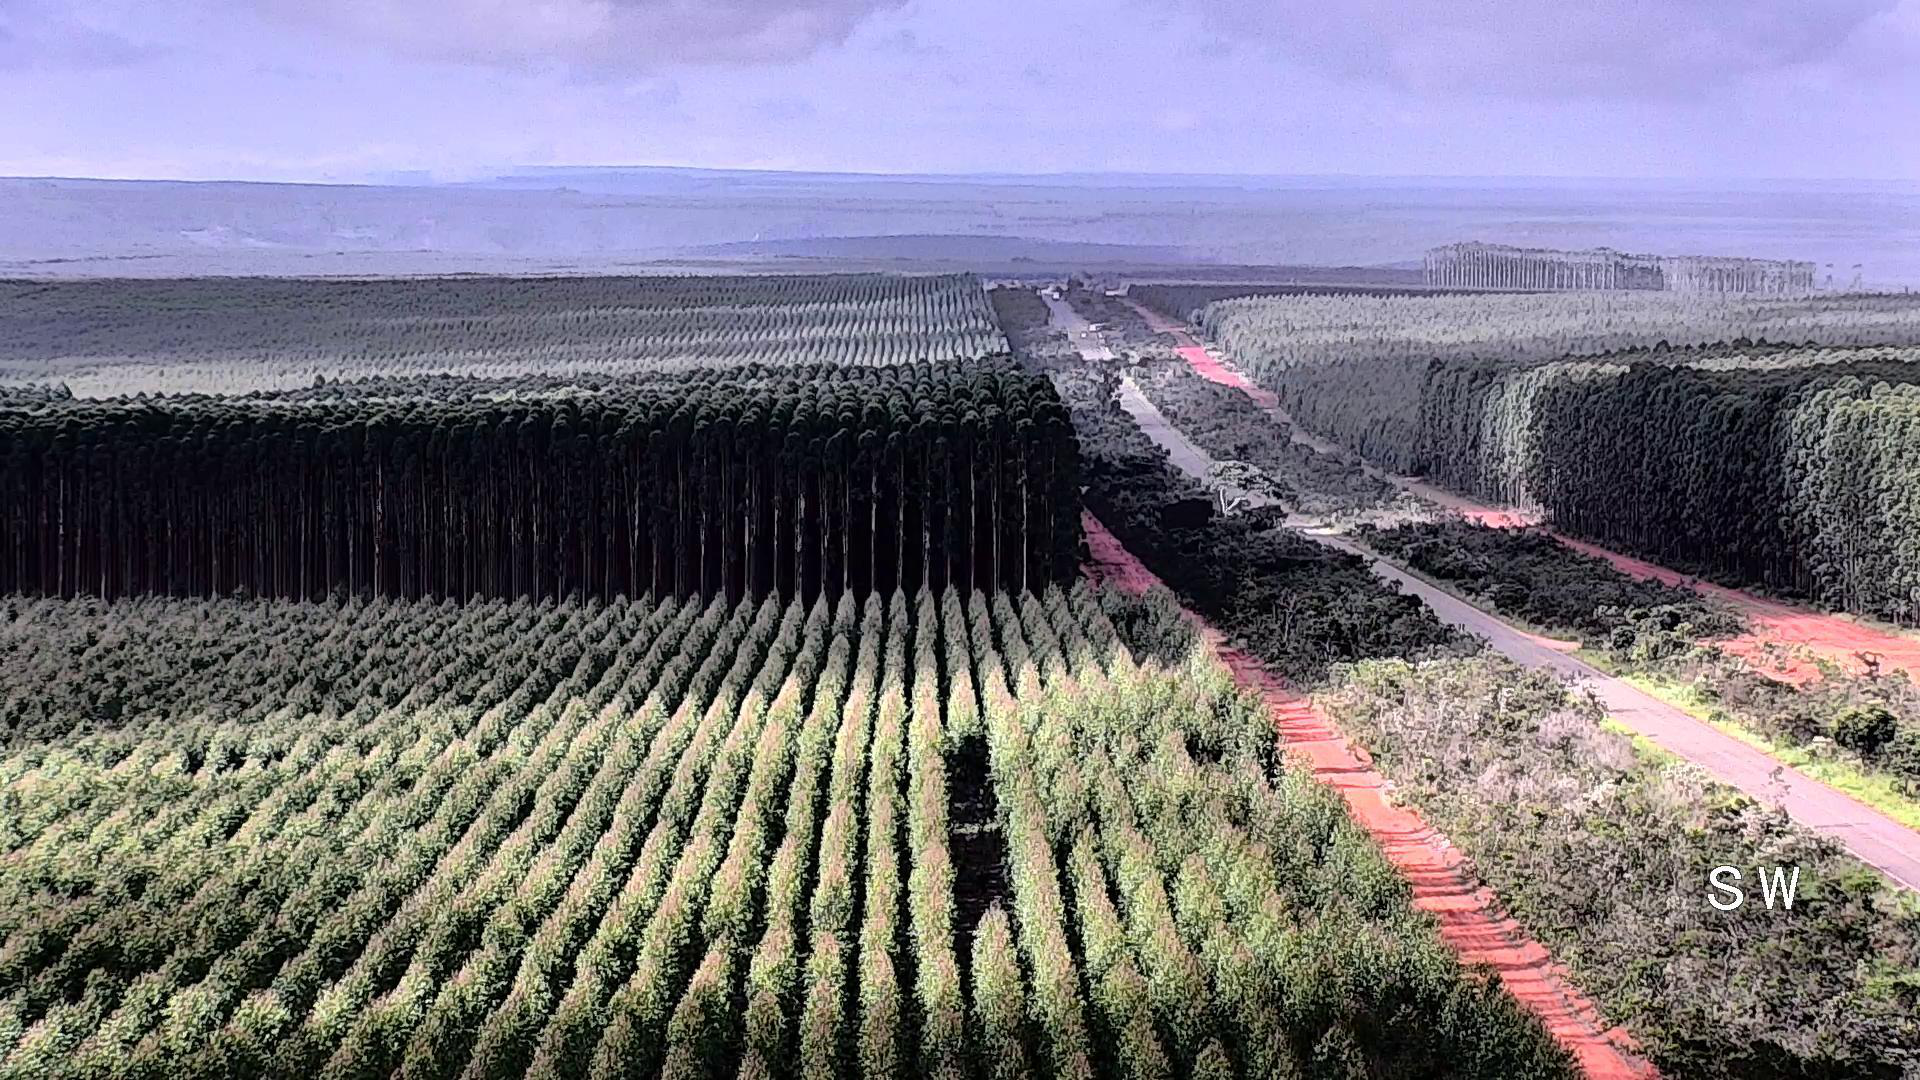

In [8]:
# Display a sample image at original size
Image.open(str(data[0][0]))

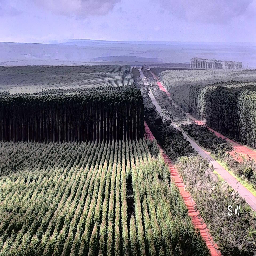

In [9]:
# Display a sample image resized size
Image.fromarray(tf.image.resize(np.array(Image.open(str(data[0][0]))), IMAGE_SIZE).numpy().astype(np. uint8))

In [10]:
train_image_df, valid_image_df, test_image_df = np.split(image_df.sample(frac=1), [int(.6*len(image_df)), int(.8*len(image_df))])

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_image_df,
    directory="/",
    x_col="image_path",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMAGE_SIZE
)

test_generator=datagen.flow_from_dataframe(
    dataframe=test_image_df,
    directory="/",
    x_col="image_path",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid_image_df,
    directory="/",
    x_col="image_path",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMAGE_SIZE
)

Found 4515 validated image filenames belonging to 2 classes.
Found 1505 validated image filenames belonging to 2 classes.
Found 1505 validated image filenames belonging to 2 classes.


In [12]:
res_net = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [13]:
# Freeze RESNET Layers, except BatchNormalization
res_net.trainable = False

for layer in res_net.layers:
    if str(type(layer)) == "<class 'tensorflow.python.keras.layers.normalization.BatchNormalization'>":
        layer.trainable = True

In [14]:
def resnet_class_model():
    x = res_net.output
    global_average_1 = GlobalAveragePooling2D()(x)
    global_max_1 = GlobalMaxPooling2D()(x)
    concat_1 = Concatenate()([global_average_1, global_max_1])
    dropout_1 = Dropout(0.25)(concat_1)
    dense_1 = Dense(512, activation='relu')(dropout_1)
    batch_norm_1 = BatchNormalization()(dense_1)
    dropout_2 = Dropout(0.5)(batch_norm_1)
    prediction_layer = Dense(1, activation='sigmoid')(dropout_2)
    return Model(inputs=res_net.input, outputs=prediction_layer)

In [15]:
# plot_model(model, show_shapes=True)

Epoch 1/3
86/94 [==========================>...] - ETA: 7s - loss: 1.1799 - accuracy: 0.5653

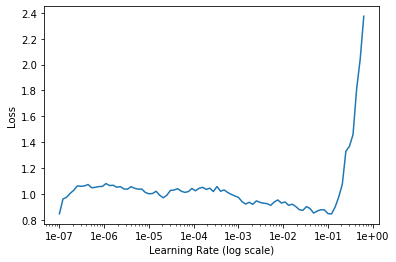

In [17]:
model = resnet_class_model()
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

lr_finder = LRFinder(max_steps=100)

history = model.fit_generator(epochs=3,
                              generator=train_generator,
                              steps_per_epoch=len(train_image_df) // BATCH_SIZE,
                              callbacks=[lr_finder], max_queue_size=75, workers=12)

lr_finder.plot()

In [18]:
lr = 1e-3
initial_epochs = 3
steps = len(train_generator) * initial_epochs

model = resnet_class_model()

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
one_cycle = OneCycleScheduler(lr, steps)

history = model.fit_generator(epochs=initial_epochs,
                              generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              callbacks=[early_stop, one_cycle],
                              max_queue_size=50, workers=12)

Epoch 1/3
95/95 [==============================] - 165s 2s/step - loss: 0.8575 - accuracy: 0.6038 - AUC: 0.6064 - val_loss: 2.7137 - val_accuracy: 0.2837 - val_AUC: 0.5502
Epoch 2/3
95/95 [==============================] - 142s 1s/step - loss: 0.6489 - accuracy: 0.7061 - AUC: 0.6501 - val_loss: 0.5981 - val_accuracy: 0.7163 - val_AUC: 0.5652
Epoch 3/3
95/95 [==============================] - 141s 1s/step - loss: 0.5904 - accuracy: 0.7349 - AUC: 0.6765 - val_loss: 0.6252 - val_accuracy: 0.7163 - val_AUC: 0.4475


In [19]:
res_net.trainable = True

In [20]:
lr = 1e-3
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs
steps = len(train_generator) * fine_tune_epochs

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(epochs=total_epochs,
                              initial_epoch = initial_epochs,
                              generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              callbacks=[early_stop],
                              max_queue_size=50, workers=6)

Epoch 4/10
95/95 [==============================] - 133s 1s/step - loss: 0.6297 - accuracy: 0.7167 - val_loss: 4.3603 - val_accuracy: 0.7163
Epoch 5/10
95/95 [==============================] - 128s 1s/step - loss: 0.5987 - accuracy: 0.7207 - val_loss: 10.9263 - val_accuracy: 0.2844
Epoch 6/10
95/95 [==============================] - 129s 1s/step - loss: 0.5695 - accuracy: 0.7216 - val_loss: 4.3702 - val_accuracy: 0.7163
Epoch 7/10
95/95 [==============================] - 129s 1s/step - loss: 0.5606 - accuracy: 0.7236 - val_loss: 0.6997 - val_accuracy: 0.7163
Epoch 8/10
95/95 [==============================] - 129s 1s/step - loss: 0.5542 - accuracy: 0.7353 - val_loss: 0.8117 - val_accuracy: 0.7163
Epoch 9/10
12/95 [==>...........................] - ETA: 1:57 - loss: 0.5102 - accuracy: 0.7622

KeyboardInterrupt: 